<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I - Introduction & préparation des données</h2>

<p>
Cette section a pour objectif de comparer deux stratégies de fusion des modèles
texte précédemment entraînés : une <b>fusion pondérée (blending)</b> et une
<b>fusion par stacking</b> reposant sur l’apprentissage d’un méta-classifieur.
Ces deux approches permettent de combiner les prédictions de plusieurs modèles,
mais reposent sur des hypothèses et des niveaux de complexité différents.
</p>

<p>
Afin de garantir une comparaison équitable et méthodologiquement rigoureuse, le
jeu de validation est scindé en deux parties distinctes selon une proportion
<b>70&nbsp;/&nbsp;30</b>. La première partie est utilisée pour
<b>l’apprentissage du méta-classifieur</b> dans le cadre du stacking (ou, plus
généralement, pour l’estimation des paramètres de fusion), tandis que la seconde
partie est exclusivement réservée à <b>l’évaluation finale</b> des deux
stratégies de fusion. Cette séparation permet d’éviter toute fuite de données et
de comparer les méthodes sur un jeu strictement indépendant de leur
paramétrisation.
</p>

<p>
Avant de procéder à la fusion, les sorties des modèles de deep learning sont
préparées de manière homogène. Les modèles basés sur des architectures
transformers produisent en sortie des <b>logits</b>, qui ne constituent pas des
probabilités directement interprétables. Ces logits sont donc <b>calibrés a
posteriori</b> à l’aide d’une méthode de <b>temperature scaling</b>, consistant à
apprendre un paramètre de température sur une sous-partie du jeu de validation,
puis à appliquer une fonction <b>softmax</b> afin d’obtenir des probabilités
calibrées. Cette étape vise à améliorer la cohérence probabiliste des prédictions,
sans modifier les classes prédites.
</p>

<p>
À l’inverse, le modèle basé sur une vectorisation <b>TF-IDF</b> et une
<b>SVM</b> produit déjà des probabilités calibrées, celles-ci ayant été obtenues
via une procédure de calibration dédiée lors de son entraînement (voir notebook
<i>text_04_vectorization.ipynb</i>). Aucune étape supplémentaire de calibration
n’est donc nécessaire pour ce modèle.
</p>

<p>
Une fois l’ensemble des sorties probabilistes harmonisées, les deux stratégies de
fusion — blending pondéré et stacking — sont mises en œuvre et évaluées sur le
même sous-ensemble d’évaluation, afin d’analyser leurs performances respectives
en termes de <b>F1-score pondéré</b> et de <b>log loss</b>.
</p>

<div/>

In [ ]:
import json

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../exploratory')
from data import load_data
from utils.calibration import fit_temperature, calibrated_probas, normalize_probas, weights_from_logloss
from visualization import plot_classification_report, plot_f1_comparison_with_delta

from sklearn.preprocessing import LabelEncoder

In [2]:
_, X_val, X_test, y_train, y_val, y_test = load_data(splitted=True).values()
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.tolist())
y_val = encoder.transform(y_val.tolist())
y_test = encoder.transform(y_test.tolist())

idx = np.arange(len(y_val))

idx_meta, idx_eval = train_test_split(
    idx,
    test_size=0.30,
    random_state=42,
    stratify=y_val
)

In [3]:
# Probabilités et logits sur la validation

logits_val_cam = np.load("../predictions/text/logits_camembert_val.npy")
logits_val_xlmr = np.load("../predictions/text/logits_xlmr_val.npy")
P_val_tfidf = np.load("../predictions/text/proba_vec_val.npy")
logits_test_cam = np.load("../predictions/text/logits_camembert_test.npy")
logits_test_xlmr = np.load("../predictions/text/logits_xlmr_test.npy")
P_test_tfidf = np.load("../predictions/text/proba_vec_test.npy")


# calibration des modèles
T_cam = fit_temperature(logits_val_cam, y_val)
T_xlmr = fit_temperature(logits_val_xlmr, y_val)
P_val_cam = calibrated_probas(logits_val_cam, T_cam)
P_val_xlmr = calibrated_probas(logits_val_xlmr, T_xlmr)
P_test_cam = calibrated_probas(logits_test_cam, T_cam)
P_test_xlmr = calibrated_probas(logits_test_xlmr, T_xlmr)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>II - Blending</h2>

<p>
Le <b>blending</b> est une stratégie de fusion tardive (<i>late fusion</i>) qui
consiste à combiner les sorties probabilistes de plusieurs modèles afin
d’obtenir une prédiction finale plus robuste. Contrairement au stacking, le
blending ne repose pas sur l’apprentissage d’un méta-classifieur, mais sur une
<b>combinaison linéaire pondérée</b> des probabilités produites par chaque modèle.
</p>

<p>
Formellement, la probabilité finale associée à une classe est définie comme une
somme pondérée des probabilités individuelles :
</p>

<p style="text-align:center;">
\( P = \sum_i w_i \cdot P_i \quad \text{avec} \quad \sum_i w_i = 1 \)
</p>

<p>
où \(P_i\) correspond aux probabilités prédites par le modèle \(i\), et \(w_i\)
au poids associé à ce modèle. Ces poids traduisent le degré de confiance accordé
à chaque source d’information dans la décision finale.
</p>

</div>

<div style="background:#f8f8ff; padding:14px; border-radius:6px">

<p>
Afin d’évaluer l’apport réel de chaque modèle dans la fusion, trois
configurations de blending sont comparées :
</p>

<ul>
  <li>
    <b>CamemBERT-large + XLM-R</b>, afin d’évaluer l’apport d’un modèle multilingue
    en complément du modèle monolingue principal ;
  </li>
  <li>
    <b>CamemBERT-large + TF-IDF</b>, afin de mesurer l’intérêt de signaux lexicaux
    classiques en complément des représentations neuronales ;
  </li>
  <li>
    <b>CamemBERT-large + XLM-R + TF-IDF</b>, correspondant à une fusion combinant
    l’ensemble des sources d’information disponibles.
  </li>
</ul>

<p>
Ces comparaisons permettent de mesurer la contribution marginale de chaque
composant, et en particulier celle de <b>XLM-R</b>, dans un cadre contrôlé et
méthodologiquement cohérent.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Les poids du blending sont déterminés à partir de la <b>log loss</b> obtenue par
chaque modèle sur le jeu de validation. La log loss, également appelée
<i>cross-entropy</i>, mesure la qualité probabiliste des prédictions : elle
pénalise fortement les prédictions incorrectes réalisées avec une forte
confiance, et favorise les modèles produisant des probabilités mieux calibrées.
</p>

<p>
Afin de refléter cette notion de fiabilité probabiliste, les poids sont définis
comme étant proportionnels à l’inverse de la log loss :
</p>

<p style="text-align:center;">
\( w_i \propto \frac{1}{\text{log\_loss}_i} \)
</p>

<p>
Cette transformation possède une interprétation mathématique directe : un
modèle présentant une log loss plus faible (donc des probabilités plus fiables)
se voit attribuer un poids plus élevé dans la fusion. Les coefficients sont
ensuite normalisés afin de sommer à un, garantissant ainsi une combinaison
convexe des probabilités.
</p>

<p>
Cette approche présente plusieurs avantages : elle ne nécessite aucun paramètre
supplémentaire à apprendre, évite toute optimisation directe des poids sur les
données d’évaluation, et respecte la hiérarchie des modèles observée
individuellement. Les poids ainsi obtenus sont ensuite figés et utilisés pour
l’évaluation des différentes stratégies de blending.
</p>

</div>


In [4]:
# --- Probabilités disponibles ---
probas = {
    "camembert": P_val_cam,
    "xlmr": P_val_xlmr,
    "tfidf": P_val_tfidf,
}

# --- Configurations de blending ---
configs = {
    "CamemBERT + XLM-R": ["camembert", "xlmr"],
    "CamemBERT + TF-IDF": ["camembert", "tfidf"],
    "CamemBERT + XLM-R + TF-IDF": ["camembert", "xlmr", "tfidf"],
}

rows = []

for config_name, models in configs.items():

    # Calcul des log loss individuelles (sur VAL_WEIGHTS ou y_val selon ton setup)
    log_losses = {
        m: log_loss(y_val, probas[m])
        for m in models
    }

    # Calcul des poids par inverse de log loss
    weights = weights_from_logloss(log_losses)

    # Blending pondéré
    P_blend = sum(weights[m] * probas[m] for m in models)
    P_blend = normalize_probas(P_blend)

    # Évaluation sur eval_idx
    y_pred = np.argmax(P_blend, axis=1)

    f1 = f1_score(
        y_val[idx_eval],
        y_pred[idx_eval],
        average="weighted"
    )

    ll = log_loss(
        y_val[idx_eval],
        P_blend[idx_eval]
    )

    # Stockage des résultats (0 pour modèles absents)
    rows.append({
        "configuration": config_name,
        "w_camembert": weights.get("camembert", 0.0),
        "w_xlmr": weights.get("xlmr", 0.0),
        "w_tfidf": weights.get("tfidf", 0.0),
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_blending = pd.DataFrame(rows).set_index("configuration")
df_blending.round(4)

,w_camembert,w_xlmr,w_tfidf,f1_weighted,log_loss
configuration,,,,,
CamemBERT + XLM-R,0.5353,0.4647,0.0000,0.9119,0.3107
CamemBERT + TF-IDF,0.5969,0.0000,0.4031,0.9105,0.3418
CamemBERT + XLM-R + TF-IDF,0.3931,0.3413,0.2655,0.9157,0.3226


<div style="background:#f0f8ff; padding:14px; border-radius:6px"> <h4>Analyse des résultats du blending</h4> <p> Les résultats obtenus pour les différentes configurations de blending mettent en évidence des écarts limités mais significatifs, tant en termes de <b>F1-score pondéré</b> que de <b>log loss</b>.</p> <p> La configuration <b>CamemBERT + XLM-R</b> présente un F1-score pondéré inférieur aux configurations intégrant le TF-IDF, mais elle se distingue par la <b>meilleure log loss observée</b>. Ce résultat indique que, bien que cette fusion n’améliore pas significativement la performance de classification, elle produit des probabilités particulièrement bien calibrées. Le poids attribué à XLM-R, proche de celui de CamemBERT, suggère que le modèle multilingue contribue à stabiliser les estimations probabilistes, notamment sur des cas plus ambigus. </p> <p> La configuration <b>CamemBERT + TF-IDF</b> obtient un F1-score comparable, mais une <b>log loss plus élevée</b>. Le poids relativement important du TF-IDF confirme que les signaux lexicaux apportent une information complémentaire efficace pour la décision finale, en particulier pour la classification, mais que cette complémentarité est moins favorable du point de vue de la calibration probabiliste. </p> <p> La configuration <b>CamemBERT + XLM-R + TF-IDF</b> obtient les <b>meilleurs résultats globaux en F1-score pondéré</b>, tout en conservant une <b>log loss maîtrisée</b>. Cette configuration représente le meilleur compromis entre performance de classification et qualité probabiliste. Les poids relativement équilibrés entre les trois modèles indiquent que chacun apporte un signal distinct : CamemBERT pour la performance globale, TF-IDF pour la robustesse lexicale, et XLM-R pour la stabilité probabiliste. </p> <p> Ces résultats montrent que, si <b>XLM-R</b> n’apporte qu’un gain limité en termes de F1-score lorsqu’il est combiné uniquement à CamemBERT, il joue un rôle plus pertinent dans une fusion enrichie intégrant des sources hétérogènes. La calibration des probabilités permet ainsi de mieux exploiter cette complémentarité, en particulier dans une optique de fusion multimodale ou de stacking ultérieur. </p> </div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>III - Stacking</h2>

<p>
Le <b>stacking</b> est une stratégie de fusion tardive plus générale que le
blending, qui consiste à apprendre explicitement une combinaison optimale des
modèles à l’aide d’un <b>méta-classifieur</b>. Contrairement au blending, où les
poids sont fixés a priori, le stacking cherche à exploiter les sorties
probabilistes des modèles de base comme des <b>features d’entrée</b> pour un
modèle supplémentaire chargé de produire la prédiction finale.
</p>

<p>
Dans ce cadre, chaque échantillon est représenté par la concaténation des
probabilités prédites par les différents modèles, et le méta-modèle apprend à
pondérer ces informations en fonction de leur utilité respective.
</p>

<p>
Le méta-classifieur retenu pour le stacking est une <b>régression logistique</b>.
Ce choix est motivé par plusieurs considérations méthodologiques. La régression
logistique constitue un modèle linéaire simple, bien adapté à la combinaison de
probabilités, et permet d’apprendre des pondérations par classe tout en limitant
le risque de sur-apprentissage.
</p>

<p>
Dans un contexte où les modèles de base sont fortement corrélés et où le volume
de données disponible pour l’apprentissage du méta-modèle est limité, ce choix
représente un compromis pertinent entre expressivité et robustesse. Des
méta-modèles plus complexes n’ont volontairement pas été explorés afin de
préserver la stabilité de l’approche.
</p>

<p>
Le méta-classifieur est entraîné sur une sous-partie du jeu de validation,
distincte de celle utilisée pour l’évaluation finale, conformément au protocole
décrit précédemment. Cette séparation permet d’éviter toute fuite de données et
de garantir une comparaison équitable entre les différentes stratégies de
fusion.
</p>

<p>
Afin de comparer directement le stacking au blending, les <b>mêmes trois
configurations</b> sont évaluées :
</p>

<ul>
  <li><b>CamemBERT-large + XLM-R</b></li>
  <li><b>CamemBERT-large + TF-IDF</b></li>
  <li><b>CamemBERT-large + XLM-R + TF-IDF</b></li>
</ul>

<p>
Cette analyse permet d’évaluer si l’apprentissage explicite d’une combinaison
des modèles permet d’améliorer les performances par rapport à une fusion
pondérée simple, ou si une approche plus contrainte se révèle plus robuste dans
ce contexte.
</p>

</div>


In [5]:
rows = []

for config_name, models in configs.items():

    # Construction des features meta (concaténation des probabilités)
    X_meta = np.concatenate([probas[m] for m in models], axis=1)

    X_meta_train = X_meta[idx_meta]
    X_meta_eval = X_meta[idx_eval]

    y_train = y_val[idx_meta]
    y_eval = y_val[idx_eval]

    # Entraînement du méta-classifieur
    meta_model = LogisticRegression(
        max_iter=3000,
        n_jobs=-1,
    )

    meta_model.fit(X_meta_train, y_train)

    # Prédictions sur le jeu d’évaluation
    P_eval = meta_model.predict_proba(X_meta_eval)

    # Sécurité : normalisation explicite
    P_eval = P_eval / P_eval.sum(axis=1, keepdims=True)

    y_pred = np.argmax(P_eval, axis=1)

    # Métriques
    f1 = f1_score(
        y_eval,
        y_pred,
        average="weighted"
    )

    ll = log_loss(
        y_eval,
        P_eval
    )

    # Stockage des résultats
    rows.append({
        "configuration": config_name,
        "f1_weighted": f1,
        "log_loss": ll,
    })


df_stacking = pd.DataFrame(rows).set_index("configuration")


scores = pd.concat([df_blending[['f1_weighted', 'log_loss']], df_stacking], axis=0)#.reset_index(['blending']*3+['stacking']*3)
scores.index = ['blending - ' + idx if i < 3 else 'stacking - ' + idx for i, idx in enumerate(scores.index)]
scores

,f1_weighted,log_loss
blending - CamemBERT + XLM-R,0.911924,0.310704
blending - CamemBERT + TF-IDF,0.910513,0.341842
blending - CamemBERT + XLM-R + TF-IDF,0.915671,0.322639
stacking - CamemBERT + XLM-R,0.910470,0.350955
stacking - CamemBERT + TF-IDF,0.910592,0.343209
stacking - CamemBERT + XLM-R + TF-IDF,0.912727,0.326125


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p> Les résultats présentés ci-dessus permettent de comparer directement les deux stratégies de fusion — <b>blending pondéré</b> et <b>stacking</b> — sur des configurations strictement identiques et sur le même jeu d’évaluation. Cette comparaison met en évidence des écarts globalement limités, mais cohérents, qui permettent d’analyser l’impact réel de la complexité de la méthode de fusion sur la performance de classification et la qualité probabiliste. </p>

<p>
Pour la configuration <b>CamemBERT + TF-IDF</b>, les deux
stratégies conduisent à des scores très proches, sans différence marquée en
termes de performance de classification. Cette stabilité suggère que la
complémentarité entre représentations neuronales et signaux lexicaux est déjà
efficacement capturée par une fusion linéaire simple.
</p>

<p>
En revanche, pour la configuration <b>CamemBERT + XLM-R</b>, le <b>blending</b>
présente un <b>F1-score légèrement supérieur</b> et surtout une
<b>log loss nettement plus faible</b> que le stacking. Cette dégradation observée
avec le stacking indique que l’apprentissage du méta-classifieur ne parvient pas
à exploiter efficacement la <b>forte redondance</b> entre les deux modèles de type
transformer, conduisant à une combinaison plus instable du point de vue
probabiliste.
</p>

<p>
La configuration <b>CamemBERT + XLM-R + TF-IDF</b> met en évidence un contraste clair
entre les deux stratégies de fusion. Le <b>blending pondéré</b> atteint le
<b>meilleur F1-score pondéré global</b> et présente également une
<b>log loss plus faible</b> que le stacking, traduisant à la fois une meilleure
performance de classification et une meilleure qualité probabiliste.
</p>

<p>
Ces observations confirment que, dans un contexte où un modèle principal
(CamemBERT-large) domine largement la performance de classification, et où les
modèles complémentaires apportent principalement des signaux marginaux, une
stratégie de fusion plus contrainte et plus simple peut s’avérer plus robuste
qu’une approche plus flexible mais plus sensible au sur-ajustement.
</p>

<p>
Au regard de l’ensemble des résultats, la configuration <b>Blending –
CamemBERT + XLM-R + TF-IDF</b> apparaît comme le <b>meilleur compromis global</b>.
Elle obtient le F1-score pondéré le plus élevé tout en conservant une log loss
raisonnablement faible, assurant un équilibre pertinent entre performance de
classification et qualité probabiliste.
</p>

<p>
En conséquence, cette configuration est retenue comme <b>modèle texte final</b>
pour la suite du projet. Elle permet d’exploiter efficacement la complémentarité
entre représentations neuronales monolingues et multilingues ainsi que signaux
lexicaux classiques, tout en maintenant une stratégie de fusion simple, stable
et méthodologiquement robuste.
</p>

<h2>IV - Evaluation du modèle de texte final</h2>

<p>
Dans la section suivante, le modèle texte retenu est évalué sur le <b>jeu de
test final</b>, strictement indépendant des phases de sélection et de fusion.
Cette évaluation permet de mesurer la capacité de généralisation réelle du
modèle fusionné et de valider les choix méthodologiques effectués tout au long
du processus.
</p>

<p>
Dans une optique de reproductibilité et de réutilisation dans les étapes
ultérieures du projet, les <b>probabilités issues du modèle texte final</b> sont
explicitement sauvegardées pour les jeux de <b>validation</b> et de
<b>test</b>. Ces sorties constituent les entrées du module de fusion multimodale
texte–image évalué par la suite.
</p>

<p>
Par ailleurs, l’ensemble des <b>paramètres de fusion</b> associés au modèle texte
final — en particulier les poids du blending et les paramètres de calibration —
est enregistré séparément. Cette approche permet de <b>dissocier l’apprentissage
des modèles de base de la phase de fusion</b>, et garantit une réutilisation
cohérente et reproductible du pipeline sans nécessiter de réentraînement
supplémentaire.
</p>


</div>


In [14]:
w_cam, w_xlmr, w_tfidf = df_blending.iloc[2,:3]
P_val = w_cam * P_val_cam + w_xlmr * P_val_xlmr + w_tfidf * P_val_tfidf
P_test = w_cam * P_test_cam + w_xlmr * P_test_xlmr + w_tfidf * P_test_tfidf

np.save("../models/fusion/text/proba_text_val.npy", P_val)
np.save("../models/fusion/text/proba_text_test.npy", P_test)

pipeline_params = {
    "weights": {
        "camembert": float(w_cam),
        "xlmr": float(w_xlmr),
        "tfidf": float(w_tfidf),
    },
    "calibration": {
        "T_camembert": float(T_cam),
        "T_xlmr": float(T_xlmr),
    }
}

with open("../models/fusion/text/pipeline_text_params.json", "w") as f:
    json.dump(pipeline_params, f, indent=2)

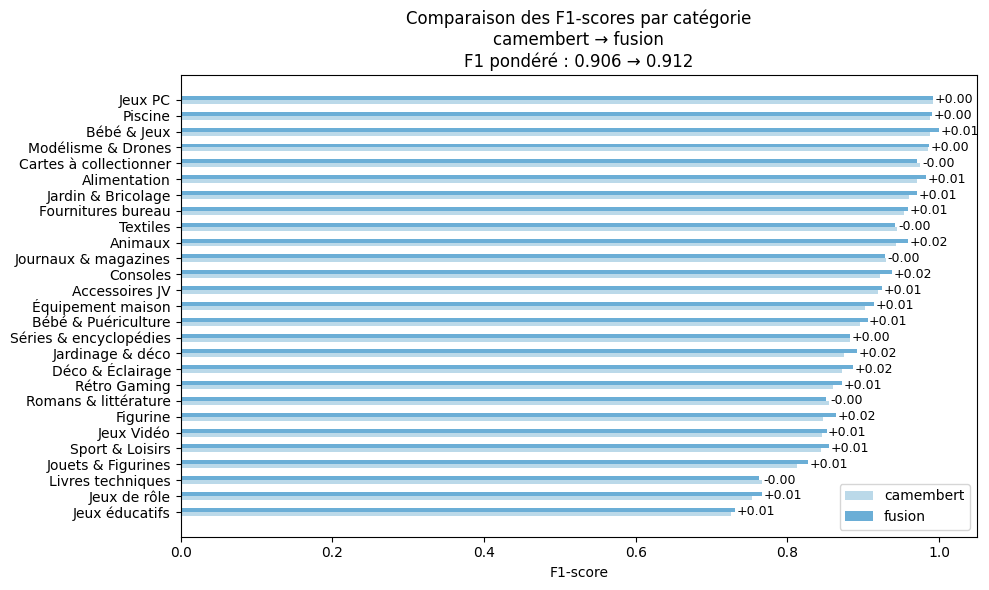

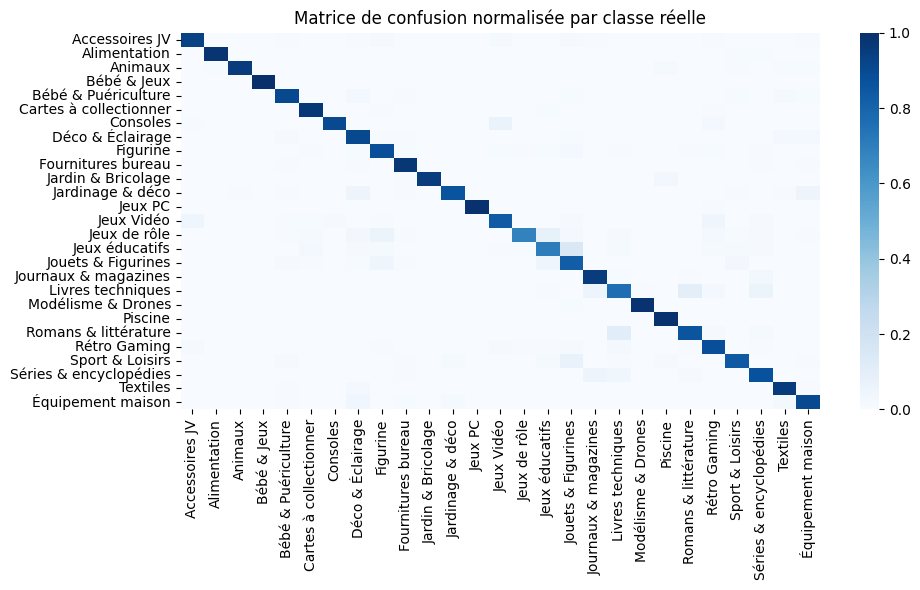


📉 Classes avec les plus faibles scores F1 (bottom 5)


,precision,recall,f1-score,support
Romans & littérature,0.845,0.857,0.851,414.0
Jouets & Figurines,0.832,0.822,0.827,731.0
Jeux de rôle,0.868,0.687,0.767,115.0
Livres techniques,0.766,0.758,0.762,467.0
Jeux éducatifs,0.760,0.704,0.731,311.0



Confusions les plus fréquentes (top 5)


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,14.5
1,Romans & littérature,Livres techniques,11.1
2,Livres techniques,Romans & littérature,9.9
3,Jeux de rôle,Jeux éducatifs,7.8
4,Sport & Loisirs,Jouets & Figurines,7.2


In [6]:
y_pred = np.argmax(P_test, axis=1)
y_pred_cam = np.argmax(P_test_cam, axis=1)

plot_f1_comparison_with_delta(y_test, y_pred, y_pred_cam, new_name="fusion", ref_name="camembert", encoder=encoder)
plot_classification_report(y_test, y_pred, encoder=encoder)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Le modèle texte final, basé sur une stratégie de <b>blending pondéré</b> combinant
<b>CamemBERT-large</b>, <b>XLM-R</b> et des features <b>TF-IDF</b>, obtient un
<b>F1-score pondéré global de 0.912</b> sur le jeu de test final. À titre de
référence, le modèle <b>CamemBERT-large seul</b> atteint un F1-score de
<b>0.906</b>, correspondant à un <b>gain absolu d’environ +0.005</b>.
Ce gain reste modéré en valeur absolue, mais il est obtenu de manière stable,
sans dégradation marquée sur les autres classes.
</p>

<p>
L’analyse détaillée par catégorie montre que la fusion bénéficie à une
<b>large majorité des classes</b>. Des améliorations régulières, comprises entre
<b>+0.01 et +0.02 de F1-score</b>, sont observées sur de nombreuses catégories,
notamment <b>Jeux de rôle</b>, <b>Jouets &amp; Figurines</b>,
<b>Déco &amp; Éclairage</b>, <b>Équipement maison</b>, <b>Rétro Gaming</b>,
<b>Animaux</b> ou encore <b>Consoles</b>. Ces catégories correspondent
principalement à des segments de taille intermédiaire, pour lesquels la
complémentarité des signaux textuels est la plus exploitable.
</p>

<p>
À l’inverse, quelques catégories présentent une <b>légère dégradation du
F1-score</b>, notamment <b>Livres techniques</b>,
<b>Romans &amp; littérature</b>, <b>Journaux &amp; magazines</b> ou
<b>Cartes à collectionner</b>. Ces variations restent toutefois très limitées
et n’affectent pas la performance globale du
modèle.
</p>

<p>
Les catégories affichant les <b>F1-scores les plus faibles</b> restent
<b>Jeux éducatifs</b>, <b>Jeux de rôle</b>,
<b>Livres techniques</b> et <b>Romans &amp; littérature</b>. Il s’agit de classes
présentant des frontières sémantiques peu nettes et des descriptions produits
souvent ambiguës ou hybrides, ce qui limite mécaniquement la performance
atteignable par un modèle basé uniquement sur le texte.
</p>

<p>
L’analyse des confusions confirme cette interprétation. Les erreurs les plus
fréquentes correspondent à des confusions sémantiquement cohérentes, telles que
<b>Jeux éducatifs</b> confondus avec <b>Jouets &amp; Figurines</b> (14,5&nbsp;% des
erreurs de la classe), ou les confusions croisées entre
<b>Romans &amp; littérature</b> et <b>Livres techniques</b>
(respectivement 11,1&nbsp;% et 9,9&nbsp;%). De même, les <b>Jeux de rôle</b> sont
principalement confondus avec <b>Jeux éducatifs</b>, reflétant des descriptions
textuelles parfois proches dans leur intention pédagogique ou ludique.
</p>

<p>
Ces confusions traduisent davantage des <b>zones grises inhérentes au problème de
classification</b> que des erreurs systématiques du modèle. Elles constituent des
axes d’amélioration potentiels, notamment via l’enrichissement des données
textuelles, l’introduction de signaux contextuels supplémentaires, ou une
extension vers une <b>fusion multimodale texte–image</b>.
</p>

<h4>Conclusion</h4>

<p>
Dans l’ensemble, les résultats obtenus sur le jeu de test confirment l’intérêt
d’une <b>fusion pondérée simple et robuste</b> pour la classification de produits
à partir du texte. Le gain observé, bien que modéré en valeur absolue, est
<b>cohérent, stable et réparti sur un large ensemble de catégories</b>, ce qui
valide les choix méthodologiques retenus.
</p>

<p>
Le modèle texte final constitue ainsi une <b>base solide et fiable</b> pour la
suite du projet, et fournit un point d’ancrage pertinent pour une extension
future vers des approches multimodales intégrant les informations visuelles.
</p>

</div>
